In [1]:
import xarray as xr
import zarr
from fsspec.implementations.http import HTTPFileSystem
fs = HTTPFileSystem()

In [2]:
# %%
# http_map = fs.get_mapper("https://eerie.cloud.dkrz.de/datasets/icon-esm-er.eerie-control-1950.ocean.gr025.2d_monthly_mean/zarr")
http_map = fs.get_mapper("https://eerie.cloud.dkrz.de/datasets/icon-esm-er.eerie-control-1950.ocean.native.2d_daily_mean/zarr")
# open as a zarr group
zg = zarr.open_consolidated(http_map, mode="r")
ds = xr.open_zarr(http_map, consolidated=True)
ds

<xarray.Dataset>
Dimensions:                              (time: 13879, ncells: 14886338,
                                          lev: 1, depth: 1, ncells_2: 22375924)
Coordinates:
    cell_sea_land_mask                   (ncells) int32 dask.array<chunksize=(14886338,), meta=np.ndarray>
  * depth                                (depth) float64 1.0
    lat                                  (ncells) float64 dask.array<chunksize=(12500000,), meta=np.ndarray>
  * lev                                  (lev) float64 0.0
    lon                                  (ncells) float64 dask.array<chunksize=(12500000,), meta=np.ndarray>
  * time                                 (time) datetime64[ns] 2002-01-01T23:...
Dimensions without coordinates: ncells, ncells_2
Data variables: (12/31)
    Wind_Speed_10m                       (time, ncells) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Evaporation    (time, ncells) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Precipitation  (time, ncells) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Runoff         (time, ncells) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    atmos_fluxes_FrshFlux_SnowFall       (time, ncells) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    atmos_fluxes_HeatFlux_Latent         (time, ncells) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    ...                                   ...
    ssh                                  (time, ncells) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    stretch_c                            (time, ncells) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    to                                   (time, depth, ncells) float32 dask.array<chunksize=(3, 1, 6967296), meta=np.ndarray>
    u                                    (time, depth, ncells) float32 dask.array<chunksize=(3, 1, 6967296), meta=np.ndarray>
    v                                    (time, depth, ncells) float32 dask.array<chunksize=(3, 1, 6967296), meta=np.ndarray>
    verticallyTotal_mass_flux_e          (time, ncells_2) float32 dask.array<chunksize=(4, 4079616), meta=np.ndarray>
Attributes: (12/35)
    CDI:                      Climate Data Interface version 2.2.0 (https://m...
    Conventions:              CF-1.6
    DOKU_License:             CC BY 4.0
    DOKU_Name:                EERIE ICON-ESM-ER eerie-control-1950 run
    DOKU_authors:             Putrasahan, D.; Kröger, J.; Wachsmann, F.
    DOKU_responsible_person:  Fabian Wachsmann
    ...                       ...
    time_max:                 28401119
    time_min:                 27351359
    time_reduction:           mean
    title:                    ICON simulation
    uuidOfHGrid:              375cb0cc-637e-11e8-9d6f-8f41a9b9ff4b
    _catalog_id:              icon-esm-er.eerie-control-1950.ocean.native.2d_...

In [3]:
ds_sel = ds.to.isel(time=1000).drop('cell_sea_land_mask').squeeze()
ds_sel = ds_sel.rename({"lon": "clon", "lat": "clat"})
ds_sel

<xarray.DataArray 'to' (ncells: 14886338)>
dask.array<getitem, shape=(14886338,), dtype=float32, chunksize=(6967296,), chunktype=numpy.ndarray>
Coordinates:
    depth    float64 1.0
    clat     (ncells) float64 dask.array<chunksize=(12500000,), meta=np.ndarray>
    clon     (ncells) float64 dask.array<chunksize=(12500000,), meta=np.ndarray>
    time     datetime64[ns] 2004-09-27T23:59:00
Dimensions without coordinates: ncells
Attributes:
    CDI_grid_type:                unstructured
    code:                         2
    long_name:                    sea water potential temperature
    number_of_grid_in_reference:  1
    standard_name:                sea_water_potential_temperature
    units:                        deg C

In [6]:
import datashader as dshader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean
from datashader.mpl_ext import dsshow

In [70]:
def basic_dshader_plot(ds_variable, lon_range, lat_range, vminmax=None, cmap='plasma'):
    fig, ax = plt.subplots(figsize=(10,5))

    # Get the data in a dataframe to use dasher plot
    df = pd.DataFrame(data={
        "var": np.squeeze(ds_variable.values),
        "x": np.rad2deg(ds_variable.clon.values),
        "y": np.rad2deg(ds_variable.clat.values),
    },)
    df = df[(df['x']>lon_range[0]) & (df['x']<lon_range[1]) & 
            (df['y']>lat_range[0]) & (df['y']<lat_range[1])]
    
    artist = dsshow(df, dshader.Point('x', 'y'), dshader.mean('var'), cmap=cmap, vmax=vminmax[1], vmin=vminmax[0], ax=ax)

    return fig, ax

In [71]:
fig, ax = basic_dshader_plot(ds_sel, lon_range=[-180, 180], lat_range=[-90, 90], vminmax=[-2, 30], cmap=cmocean.cm.thermal)

### adapt ticks

In [38]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from   cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [80]:
def dshader_plot_map(var, lon_range, lat_range, vminmax=None, cmap='plasma'):
    projection = ccrs.PlateCarree()
    if lon_range is None:
        lon_range = [-180, 180]
    if lat_range is None:
        lat_range = [-90, 90]
        
    fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection': projection})
    fig.canvas.draw_idle()  # necessary to make things work

    #-- transform radians to geodetic coordinates
    coords = projection.transform_points(
                            ccrs.Geodetic(),
                            np.rad2deg(var.clon.values),
                            np.rad2deg(var.clat.values))
    # Get the data in a dataframe to use dasher plot
    df = pd.DataFrame(data={
        "var": np.squeeze(var.values),
        "x": coords[:,0], 
        "y": coords[:,1],
    },)
    
    df = df[(df['x']>lon_range[0]) & (df['x']<lon_range[1]) & 
            (df['y']>lat_range[0]) & (df['y']<lat_range[1])]
    
    artist = dsshow(df, dshader.Point('x', 'y'), dshader.mean('var'), cmap=cmap, vmax=vminmax[1], vmin=vminmax[0], ax=ax)
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=7)
    # add longitude and latitude labels
    ax.set_xticks(np.arange(lon_range[0], lon_range[1], 4), crs=projection)
    ax.set_yticks(np.arange(lat_range[0], lat_range[1], 4), crs=projection)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5)) # type: ignore
    ax.yaxis.set_major_locator(plt.MaxNLocator(5)) # type: ignore

    # apply the default formatter to the ticks
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    return fig, ax

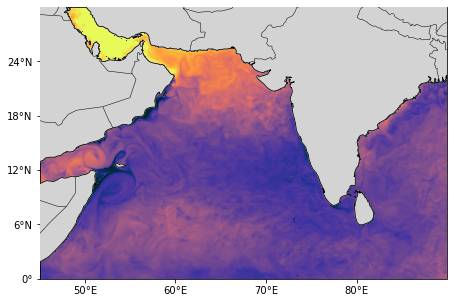

In [81]:
fig, ax = dshader_plot_map(ds_sel, lon_range=[45, 90], lat_range=[0, 30], vminmax=[24, 30], cmap=cmocean.cm.thermal)

## dshader and projections

In [83]:
def plot_dshader_proj(var, projection, extent, vmin, vmax, cmap, savefig, fig_path):
    #-- transform radians to geodetic coordinates
    coords = projection.transform_points(
                            ccrs.Geodetic(),
                            np.rad2deg(var.clon.values),
                            np.rad2deg(var.clat.values))

    #-- create data frame of the variable values and the geodetic coordinates.
    df = pd.DataFrame({'var': var.values, 'x': coords[:,0], 'y': coords[:,1]})
    fig, ax = plt.subplots(figsize=(10,5), subplot_kw={"projection": projection})
    fig.canvas.draw_idle()  # necessary to make things work


    artist = dsshow(df          = df,
                    glyph       = dshader.Point('x', 'y'),
                    aggregator  = dshader.mean('var'),
                    vmin        = vmin,
                    vmax        = vmax,
                    cmap        = cmap,
                    # plot_width  = 200,
                    # plot_height = 100,
                    ax          = ax)

    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=10)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=11)

    if extent is not None:
        ax.set_extent(extent)

    if savefig:
        plt.savefig(f'{fig_path}/test.png', dpi=250)
    return fig, ax


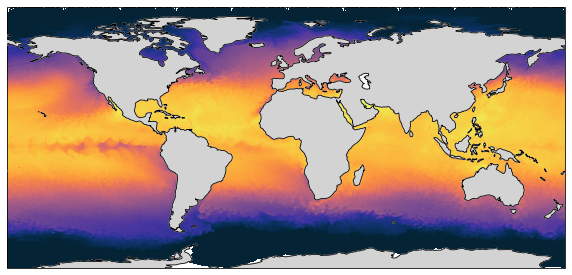

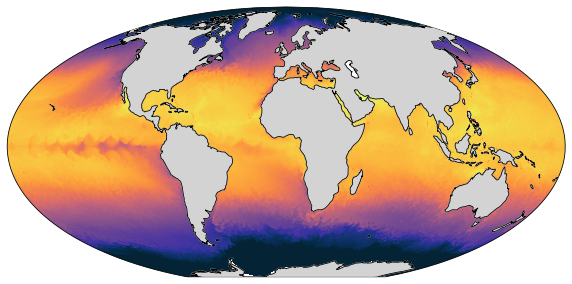

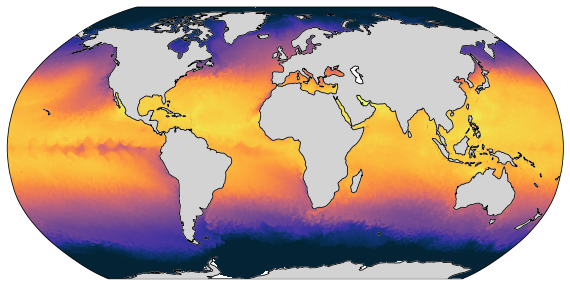

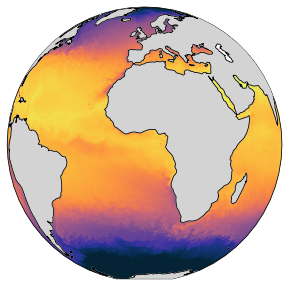

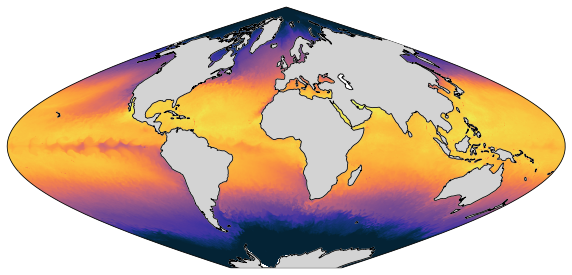

In [84]:
projections = [ccrs.Mollweide(), ccrs.InterruptedGoodeHomolosine(), ccrs.Orthographic(), ccrs.Sinusoidal(), ccrs.AzimuthalEquidistant(), ccrs.AlbersEqualArea()]
for i in range(len(projections)):
    fig, ax = plot_dshader_proj(ds_sel, projection = projections[i], extent=None, vmin=-2, vmax=30, cmap=cmocean.cm.thermal, savefig=False, fig_path=None)


## select number of pixel and save image

/home/m/m300878/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


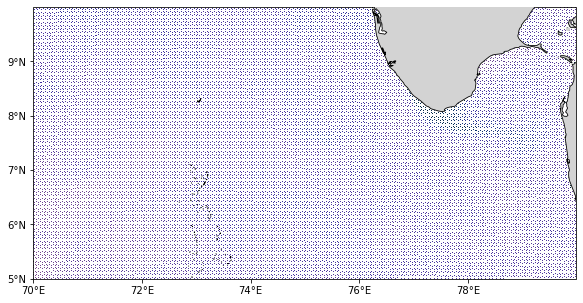

In [91]:
fig, ax = dshader_plot_map(ds_sel, lon_range=[70, 80], lat_range=[5, 10], vminmax=[24, 30], cmap=cmocean.cm.thermal)

In [ ]:
?